# Data Cleaning

## Import Data

In [6]:
import pandas as pd

file_path = "data_collection/clean_jakarta.csv"

df = pd.read_csv(file_path)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23673 entries, 0 to 23672
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location       23673 non-null  object 
 1   price          23672 non-null  float64
 2   certif         23673 non-null  object 
 3   furnish        23673 non-null  object 
 4   bed            23361 non-null  float64
 5   bath           23309 non-null  float64
 6   carport        17800 non-null  float64
 7   land_area      23673 non-null  int64  
 8   building_area  23648 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.6+ MB


## Drop None Price

In [8]:
df.dropna(subset=["price"], inplace=True)

df

,location,price,certif,furnish,bed,bath,carport,land_area,building_area
0,"Kemang, Jakarta Selatan",5.100000e+10,SHM,furnished,6.0,4.0,6.0,1300,700.0
1,"Pangeran Jayakarta, Jakarta Pusat",4.730000e+08,SHM,furnished,2.0,1.0,NaN,26,43.0
2,"Kebon Jeruk, Jakarta Barat",2.000000e+09,SHM,furnished,4.0,4.0,NaN,121,150.0
3,"Pantai Mutiara, Jakarta Utara",3.500000e+10,SHM,furnished,4.0,7.0,NaN,425,1000.0
4,"Lenteng Agung, Jakarta Selatan",4.000000e+09,SHM,furnished,9.0,9.0,5.0,543,200.0
...,...,...,...,...,...,...,...,...,...
23668,"Panglima Polim, Jakarta Selatan",2.900000e+10,HGB,unfurnished,8.0,3.0,4.0,532,485.0
23669,"Radio Dalam, Jakarta Selatan",5.000000e+09,HGB,unfurnished,3.0,3.0,NaN,125,334.0
23670,"Lebak Bulus, Jakarta Selatan",1.000000e+10,HGB,unfurnished,3.0,3.0,2.0,206,276.0
23671,"Tanah Kusir, Jakarta Selatan",6.000000e+09,HGB,unfurnished,6.0,3.0,2.0,484,512.0


In [9]:
df.describe()

,price,bed,bath,carport,land_area,building_area
count,2.367200e+04,23360.000000,23308.000000,17800.000000,23672.000000,2.364700e+04
mean,1.161496e+10,5.338185,4.313498,2.280337,349.157486,8.251964e+02
std,2.278454e+10,7.621826,6.093613,2.575509,3918.538929,5.371314e+04
min,1.300000e+07,1.000000,1.000000,1.000000,1.000000,1.000000e+00
25%,2.000000e+09,3.000000,2.000000,1.000000,108.000000,1.440000e+02
50%,5.000000e+09,4.000000,3.000000,2.000000,196.000000,2.500000e+02
75%,1.100000e+10,5.000000,4.000000,2.000000,375.000000,4.500000e+02
max,5.500000e+11,116.000000,110.000000,106.000000,597233.000000,8.001999e+06


## Remove Outliers

In [10]:
def remove_outliers(df, column):
  temp_df = df[df[column].notna()]
  df.drop(temp_df.index, inplace=True)

  first_quart = temp_df[column].quantile(0.25)
  third_quart = temp_df[column].quantile(0.75)

  iqr = third_quart - first_quart

  upper_limit = third_quart + 1.5*iqr
  lower_limit = first_quart - 1.5*iqr

  temp_df = temp_df[temp_df[column] < upper_limit]
  temp_df = temp_df[temp_df[column] > lower_limit]

  return pd.concat([df, temp_df])

In [11]:
new_df = df.copy()

In [12]:
new_df = new_df[(new_df["building_area"] >= 36) & (new_df["land_area"] >= 36)]

In [13]:
for column in ["bed", "bath", "land_area", "building_area", "price", "carport"]:
  new_df = remove_outliers(new_df, column)

In [14]:
new_df.describe()

,price,bed,bath,carport,land_area,building_area
count,1.608700e+04,15908.000000,15899.000000,12191.00000,16087.000000,16087.000000
mean,3.989764e+09,3.641501,2.910875,1.52588,175.991981,218.098154
std,3.144760e+09,1.118279,1.060941,0.58709,111.916743,127.342791
min,1.300000e+07,1.000000,1.000000,1.00000,36.000000,36.000000
25%,2.000000e+09,3.000000,2.000000,1.00000,92.000000,120.000000
50%,3.000000e+09,4.000000,3.000000,1.00000,144.000000,194.000000
75%,5.000000e+09,4.000000,4.000000,2.00000,225.000000,300.000000
max,1.400000e+10,7.000000,6.000000,3.00000,707.000000,677.000000


In [15]:
new_df["location"].str.split(",", expand=True)[1].value_counts()

1
Jakarta Timur      4190
Jakarta Barat      3537
Jakarta Utara      3196
Jakarta Selatan    3109
Jakarta Pusat      2055
Name: count, dtype: int64

## Convert Location

In [16]:
from geopy.geocoders import Nominatim

def get_lat_long(location):
  geolocator = Nominatim(user_agent="my-app")
  loc = geolocator.geocode(location)

  return loc.latitude, loc.longitude

In [17]:
from tqdm import tqdm

unique_loc = new_df["location"].unique()

loc_to_geo = {}

for loc in tqdm(unique_loc):
  try:
    loc_to_geo[loc] = get_lat_long(loc)
  except:
    loc_to_geo[loc] = (None, None)

100%|██████████| 283/283 [02:15<00:00,  2.10it/s]


## Get latitude and longitude

In [18]:
latitude_map = dict((loc, geo[0]) for loc, geo in loc_to_geo.items())
longitude_map = dict((loc, geo[1]) for loc, geo in loc_to_geo.items())

In [19]:
new_df["latitude"] = new_df["location"]

new_df.replace(
    {"location": longitude_map, "latitude": latitude_map},
    inplace=True
)

C:\Users\alfia\AppData\Local\Temp\ipykernel_14248\795568029.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df.replace(


In [20]:
new_df.rename({"location": "longitude"}, axis=True, inplace=True)

new_df

,longitude,price,certif,furnish,bed,bath,carport,land_area,building_area,latitude
1654,106.739247,1.300000e+10,SHM,furnished,NaN,NaN,NaN,144,300.0,-6.108915
2378,106.727585,7.000000e+09,SHM,furnished,NaN,NaN,NaN,200,500.0,-6.206060
3615,106.783656,5.000000e+09,SHM,unfurnished,NaN,NaN,NaN,153,165.0,-6.267214
3954,106.830653,2.000000e+09,SHM,unfurnished,NaN,NaN,NaN,121,200.0,-6.176684
4159,106.804921,3.000000e+09,SHM,unfurnished,NaN,NaN,NaN,176,170.0,-6.271720
...,...,...,...,...,...,...,...,...,...,...
23657,106.777782,7.000000e+09,HGB,unfurnished,4.0,2.0,1.0,250,150.0,-6.249128
23658,106.779691,9.000000e+09,HGB,unfurnished,3.0,2.0,2.0,222,378.0,-6.301672
23659,106.764836,5.000000e+08,HGB,unfurnished,2.0,1.0,1.0,160,40.0,-6.268226
23670,106.779691,1.000000e+10,HGB,unfurnished,3.0,3.0,2.0,206,276.0,-6.301672


In [21]:
new_df.describe()

,longitude,price,bed,bath,carport,land_area,building_area,latitude
count,12784.000000,1.608700e+04,15908.000000,15899.000000,12191.00000,16087.000000,16087.000000,12784.000000
mean,106.824669,3.989764e+09,3.641501,2.910875,1.52588,175.991981,218.098154,-6.195359
std,0.071916,3.144760e+09,1.118279,1.060941,0.58709,111.916743,127.342791,0.060980
min,106.697513,1.300000e+07,1.000000,1.000000,1.00000,36.000000,36.000000,-6.356108
25%,106.764836,2.000000e+09,3.000000,2.000000,1.00000,92.000000,120.000000,-6.234138
50%,106.819422,3.000000e+09,4.000000,3.000000,1.00000,144.000000,194.000000,-6.181214
75%,106.883675,5.000000e+09,4.000000,4.000000,2.00000,225.000000,300.000000,-6.159897
max,106.961717,1.400000e+10,7.000000,6.000000,3.00000,707.000000,677.000000,-6.108915


# Pre Processing Data

In [22]:
X = new_df.drop("price", axis=1)
y = new_df["price"]

## Split Data

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Categorical Features

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

cat_preprocess = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
)

cat_preprocess

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder', OrdinalEncoder())])

## Numerical Features

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class BuildingRatio(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X["land_to_build"] = X["building_area"]/X["land_area"]
    X["bath_to_bed"] = X["bath"]/X["bed"]
    X["build_to_bed"] = X["building_area"]/X["bed"]

    return X

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

impute_preprocess = ColumnTransformer([
    ("carport", SimpleImputer(strategy="constant", fill_value=0), ["carport"]),
    ("others", SimpleImputer(strategy="median"), ["longitude", "latitude", "bed", "bath", "land_area", "building_area",])
])

num_preprocess = make_pipeline(
    impute_preprocess,
    StandardScaler()
)

num_preprocess

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('carport',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['carport']),
                                                 ('others',
                                                  SimpleImputer(strategy='median'),
                                                  ['longitude', 'latitude',
                                                   'bed', 'bath', 'land_area',
                                                   'building_area'])])),
                ('standardscaler', StandardScaler())])

## Preprocessing Pipeline

In [27]:
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer([
    ("categorical feature", cat_preprocess, ["certif", "furnish"]),
    ("numerical feature", num_preprocess, ["longitude", "latitude", "bed", "bath", "carport", "land_area", "building_area"])
])

preprocess.fit(X_train)

ColumnTransformer(transformers=[('categorical feature',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['certif', 'furnish']),
                                ('numerical feature',
                                 Pipeline(steps=[('columntransformer',
                                                  ColumnTransformer(transformers=[('carport',
                                                                                   SimpleImputer(fill_value=0,
                                                                                                 strategy='constant'),
                                                                                   ['carport']),
                                                                                  ('others',
                                                                                   SimpleImputer(strategy='median'),
                                                                                   ['longitude',
                                                                                    'latitude',
                                                                                    'bed',
                                                                                    'bath',
                                                                                    'land_area',
                                                                                    'building_area'])])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'bed', 'bath',
                                  'carport', 'land_area', 'building_area'])])

## Transform Features

In [28]:
X_train_trans = preprocess.transform(X_train)
X_test_trans = preprocess.transform(X_test)

In [63]:
test = {
  "latitude": 1.12312,
  "longitude": 0,
  "certif": "string",
  "furnish": "string",
  "bed": 0,
  "bath": 0,
  "carport": 0,
  "land_area": 0,
  "building_area": 0
}

df = pd.DataFrame(test, index=[0])

# Training

## Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

In [30]:
lr_model.fit(X_train_trans, y_train)

LinearRegression()

In [31]:
lr_predict = lr_model.predict(X_test_trans)

(0.0, 10000000000.0)

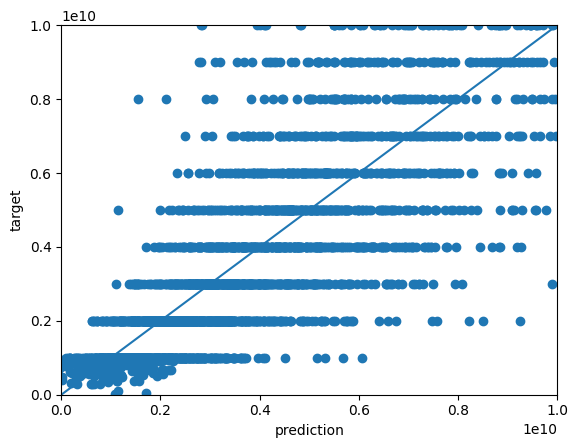

In [33]:
import numpy as np
from matplotlib import pyplot as plt

plt.scatter(lr_predict, y_test)
plt.plot(
    np.array([0, 100000000000]),
    np.array([0, 100000000000])
)

plt.xlabel("prediction")
plt.ylabel("target")

plt.xlim(0, 10000000000)
plt.ylim(0, 10000000000)

In [34]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(lr_predict, y_test)

1924625207.3828204

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

In [36]:
rf_model.fit(X_train_trans, y_train)

RandomForestRegressor()

In [37]:
rf_predict = rf_model.predict(X_test_trans)

(0.0, 10000000000.0)

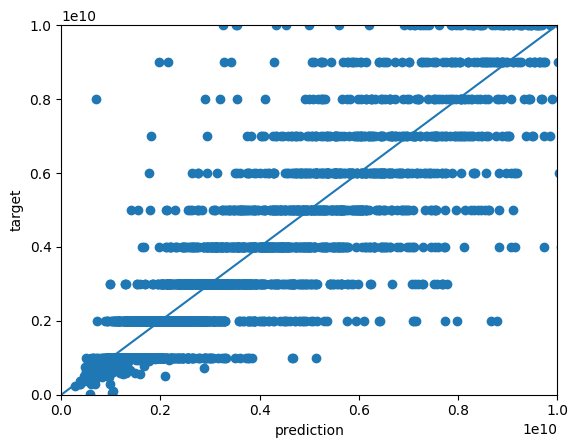

In [38]:
plt.scatter(rf_predict, y_test)
plt.plot(
    np.array([0, 100000000000]),
    np.array([0, 100000000000])
)

plt.xlabel("prediction")
plt.ylabel("target")

plt.xlim(0, 10000000000)
plt.ylim(0, 10000000000)

In [39]:
root_mean_squared_error(rf_predict, y_test)

1464641271.1628182

## XGBoost

In [40]:
from xgboost import XGBRegressor

xg_model = XGBRegressor()

In [41]:
xg_model.fit(X_train_trans, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
xg_predict = xg_model.predict(X_test_trans)

(0.0, 10000000000.0)

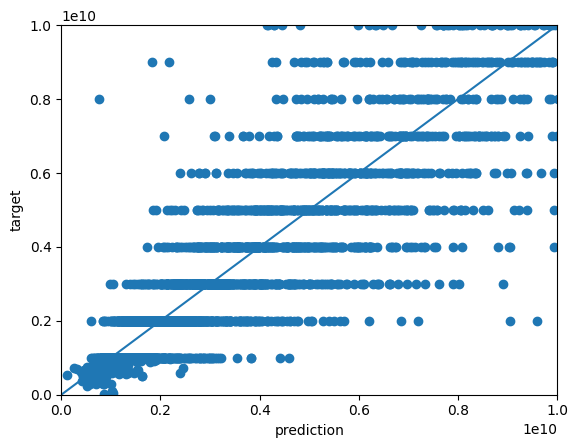

In [43]:
plt.scatter(xg_predict, y_test)
plt.plot(
    np.array([0, 10000000000]),
    np.array([0, 10000000000])
)

plt.xlabel("prediction")
plt.ylabel("target")

plt.xlim(0, 10000000000)
plt.ylim(0, 10000000000)

In [44]:
root_mean_squared_error(xg_predict, y_test)

1489290160.8309822

## Save Best Model: Random Forest

In [46]:
import pickle

# Save model
with open("model/model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Save data processing pipeline
with open("model/pipeline.pkl", "wb") as f:
    pickle.dump(preprocess, f)